# Overview over simulation output

## Create domain averaged data

In [ ]:
#!/usr/bin/env python3                                                                                                                                                                                    
#SBATCH --job-name=dommean
#SBATCH --partition=compute
#SBATCH --account=bm1183
#SBATCH --nodes=1
#SBATCH --time=08:00:00
#SBATCH --mail-type=fail,end
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=%j_%x.log

# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)
    
import sys 
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh
import xarray as xr
import postprocessing as pp

def open_pair(ifile):
    datasets = list()
    data = xr.open_dataset(ifile).load()
    data = pp.clean_surface_data(data)
    datasets.append(data)
    data = xr.open_dataset(ifile.replace('surface', 'radiation')).load()
    data = pp.clean_surface_data(data)
    datasets.append(data)
    data = xr.merge(datasets)
    return data

def add_control(input_data, domain='DOM01'):
    datasets = list()
    for kind in ['surface', 'radiation']:
        data = fh.eureca_data_from_keywords([kind, domain])
        datasets.append(data)
    datasets = pp.subset_time_overlap(datasets)
    data = xr.merge(datasets)
    data = data.expand_dims(exp=('control',))

    datasets = [input_data.expand_dims(exp=('warming',)), data]
    datasets = pp.filter_common_vars(datasets)
    datasets = pp.subset_time_overlap(datasets)
    return xr.concat(datasets, dim='exp')
    
def compute_quantiles(data):
    # This is the somewhat convoluted replacement for:
    # datasets = [data.mean(dim=['cell'], keep_attrs=True, skipna=True).expand_dims(quantile=(-1,))]
    # which was not working properly and i could not figure out why
    data = data.chunk(dict(cell=-1))
    mean_datasets = []
    for t in range(len(data.time)):
        slice_data = data.isel(time=t)
        mean_slice = slice_data.mean(dim=['cell'], keep_attrs=True, skipna=True)
        mean_slice = mean_slice.expand_dims('time').assign_coords(time=[data.time.values[t]])
        mean_datasets.append(mean_slice)
    combined_mean_data = xr.concat(mean_datasets, dim='time')
    combined_mean_data = combined_mean_data.expand_dims('quantile').assign_coords(quantile=[-1])
    datasets = [combined_mean_data] 
    # Calculate quantiles and directly use the 'quantile' coordinate                                                              
    for q in [0, 0.05, 0.25, 0.5, 0.75, 0.95, 1]: 
        quantile_data = data.quantile(q, dim=['cell'], keep_attrs=True).expand_dims('quantile').assign_coords(quantile=[q])
        datasets.append(quantile_data)
    data = xr.concat(datasets, dim='quantile')
    return data

path   = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
files  = fh.list_files(path, ['surface', 'DOM01'], full_path=True)
files += fh.list_files(path, ['surface', 'DOM02'], full_path=True)

for ifile in files:
    print(ifile)
    ofile = ifile.replace('surface', 'domainmean5')
    #ofile = ofile.replace(path, '/scratch/m/m300872/temp') # for testing

    if os.path.exists(ofile):
        print('\texists')
    else:
        data = open_pair(ifile)
        data = add_control(data)

        data = pp.add_grid(data)
        data = pp.cut_borders(data)

        data = compute_quantiles(data)

        print('\tsaving to:\n\t', ofile)
        data.to_netcdf(ofile)

## Plot the data

In [30]:
import sys 
import os
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

import file_handling as fh

d = fh.disk_data_from_keywords('/scratch/m/m300872/temp', ['domainmean5'])

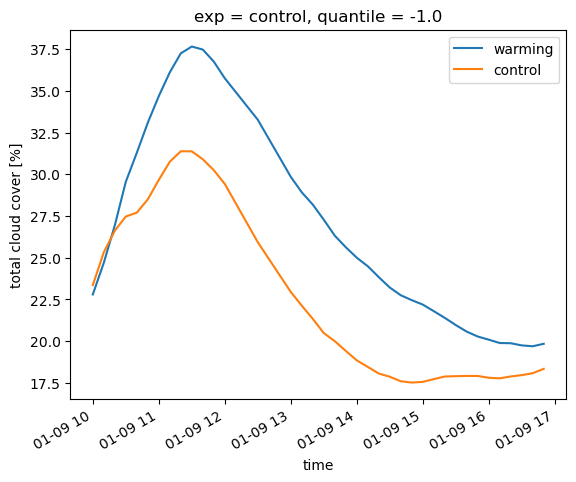

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
for exp in d.exp.values:
    d.sel({'quantile':-1, 'exp':exp})['clct'].plot(ax=ax, label=exp)
ax.legend()

In [32]:
import os

path = '/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05'
n_2d_red = len([f for f in os.listdir(path) if 'domainmean5' in f])
n_3d_red = len([f for f in os.listdir(path) if 'profile' in f])
n_2d_raw = len([f for f in os.listdir(path) if 'surface' in f])
n_3d_raw = len([f for f in os.listdir(path) if '3D' in f])
n_cltmsk = len([f for f in os.listdir(path) if 'cloudmaskedmean' in f])

print("State of postprocessing:")
print(f"2D data: {n_2d_red}/{n_2d_raw} (={n_2d_red/n_2d_raw:.2f})", 'COMPLETE' if n_2d_red == n_2d_raw else '')
print(f"3D data: {n_3d_red}/{n_3d_raw} (={n_3d_red/n_3d_raw:.2f})", 'COMPLETE' if n_3d_red == n_3d_raw else '')
print(f"cltmask: {n_cltmsk}/{n_2d_raw} (={n_cltmsk/n_2d_raw:.2f})", 'COMPLETE' if n_cltmsk == n_2d_raw else '')

State of postprocessing:
2D data: 164/872 (=0.19) 
3D data: 198/422 (=0.47) 
cltmask: 748/872 (=0.86) 


In [ ]:
stop()

In [ ]:
#!/usr/bin/env python3                                                                                                                                                     
#SBATCH --job-name='sst'
#SBATCH --account=bm1183
#SBATCH --partition=compute
#SBATCH --array=0-200%3
#SBATCH --time=02:00:00
#SBATCH --mail-type=fail
#SBATCH --mail-user=hernan.campos@mpimet.mpg.de
#SBATCH --output=/scratch/m/m300872/log/%j_%x.log

import sys 
module_path = '/home/m/m300872/warm_eurec4a/submodules/'
if not module_path in sys.path: sys.path.append(module_path)

# avoid dask warnings in the output
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})

import builtins
def print(*args, **kwargs):
    ''' for printing into SLURM logs'''
    builtins.print(*args, **kwargs, flush=True)

import pandas as pd
import eurec4a
import xarray as xr    
import numpy as np
import postprocessing as pp
import file_handling as fh
import calculations as cc

import matplotlib.pyplot as plt
import matplotlib.dates
import plot_utils as pu

def save_composit_timeseries(path, savename, cut_borders=True):
    files = [os.path.join(path,f) for f in os.listdir(path) if 'surface' in f]
    files = [f for f in files if 'DOM01' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell', keep_attrs=True)
    
    files = [os.path.join(path,f) for f in os.listdir(path) if 'radiation' in f]
    files = [f for f in files if 'DOM01' in f]
    data = pp.open_mfdataset_with_timedoubles(files)
    data = pp.clean_surface_data(data)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell', keep_attrs=True)
    
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)

def save_matching_eurecadata(data_to_match, savename, cut_borders=True):
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.surface_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    surface = data.mean(dim='cell')
    data = eurec4a.get_intake_catalog().simulations.ICON.LES_CampaignDomain_control.radiation_DOM01.to_dask()
    data = data.where(data.time < data_to_match.time.values[-1], drop=True)
    if cut_borders:
        data = pp.add_grid(data)
        data = pp.cut_borders(data)
    radiation = data.mean(dim='cell').drop_vars('height_bnds').drop_dims(['height'])
    composit = xr.merge(pp.time_overlap([surface,radiation]))
    composit.to_netcdf(savename)
            
                
def fig_all_domain_means(data, labels, kwargs=False, verbose=False, integral=False, mean=False, figsize=(20,10)):
    if not kwargs: kwargs = [dict() for d in data]
    m, n = cc.isqrt(len(list(data[0])))
    if verbose: print(len(list(data[0])) * len(list(data)), ' plots: ', end='')
    fig,axs = plt.subplots(m,n, figsize=figsize)

    for i,var in enumerate(list(data[0])):
        ax = np.ravel(axs)[i]
        for j, d in enumerate(data):
            if verbose: print(f'{i*(j+1) + j} {var}', end=', ')
            if mean:
                integral = np.mean(d[var].values[d[var].values != -np.inf])
                ax.axhline(integral, ls=':', color=kwargs[j]['color'])
            x = d[var].time
            y = d[var]
            ax.plot(x, y, label=f'{labels[j]}, mean={integral:3f}', **kwargs[j])
        ax.set_title(y.attrs['long_name'])
        ax.legend()
        ax = pu.remove_spines(ax, ['top', 'right'])
        
        def format_dates_on_axis(ax, format_string='%d-%H:%m', rotation=45):
            ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter(format_string))
            if not rotation == None: ax.tick_params(axis='x', rotation=rotation)
            return ax
        
        ax = format_dates_on_axis(ax)

    for i in range(m*n - len(list(data[0]))): # remove empty plots
        pu.remove_spines(np.ravel(axs)[-(1+i)], ['left','right','top','bottom'])
        pu.remove_ticks(np.ravel(axs)[-(1+i)], ['left','right','top','bottom'])

    if verbose: print('done')
    return fig, axs

def fixedfig_all_domain_means_warmingrun(verbose=False, time=None, mean=False):
    warming_timeseries = f'data/moistadabatic_{fh.timestamp(time)}.nc'
    control_timeseries = f'data/eurecasurface_{fh.timestamp(time)}.nc'
    if not os.path.exists(warming_timeseries):
        print(f'creating time series data: {warming_timeseries}')
        save_composit_timeseries('/work/mh1126/m300872/eureca_icon/EUREC4A/experiments/moist_adiabatic_05', warming_timeseries)
    if not os.path.exists(control_timeseries):
        print(f'creating time series data: {control_timeseries}')
        warm = xr.open_dataset(warming_timeseries)
        save_matching_eurecadata(warm, control_timeseries)
    
    ctrl = xr.open_dataset(control_timeseries)
    warm = xr.open_dataset(warming_timeseries)
    data = {'ctrl':ctrl, 'warm':warm}
    labels = list(data.keys())
    data = list(data.values())
    kwargs = [ dict()] * (len(data)-1) + [{'ls' : ':'}]
    kwargs = [{'ls' : ':', 'color':'tab:blue'}, {'color':'tab:orange'}]
    
    fig, axs = fig_all_domain_means(data, labels, kwargs, verbose=verbose, mean=mean)
    np.ravel(axs)[0].legend()
    fig.tight_layout()
    return fig, axs 

fig, axs = fixedfig_all_domain_means_warmingrun(time=pd.to_datetime('20250128'), mean=True)
fig.show()